# Importing Packages

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import differential_entropy,kurtosis
import pandas as pd
from scipy.optimize import minimize
import statsmodels.api as sm
from tqdm import tqdm
from copy import deepcopy
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import yfinance as yf

# Majewski Model Simulation

The `Majew` function simulates financial time series data based on the Majewski et al. model. This model incorporates :
- `gamma`: Controls the sensitivity to the trend.
- `alpha`: Smoothing parameter for the trend.
- `kappa1`: Strength of the mean-reversion to the fundamental value.
- `beta`: Strength of the nonlinear response to the trend.
- `Lambda`: Smoothing parameter for the fundamental value.
- `sigmav`: Standard deviation of the noise term added to the price.

The function returns the simulated price (`p`) and return (`r`) time series.


In [8]:
def Majew(gamma, alpha, kappa1, beta, Lambda, sigmav, length=1000, nb=1):
    """
    Simulate the Majewski et al. model for financial time series.

    Parameters:
    gamma (float): Parameter gamma in the model.
    alpha (float): Parameter alpha in the model.
    kappa1 (float): Parameter kappa1 in the model.
    beta (float): Parameter beta in the model.
    Lambda (float): Parameter Lambda in the model.
    sigmav (float): Standard deviation of the noise term.
    length (int): Length of the time series to simulate. Default is 1000.
    nb (int): Number of simulations to run. Default is 1.

    Returns:
    tuple: Simulated price (p) and return (r) time series.
    """


    # Generate random noise for the simulations
    Epsilon = np.random.normal(0, sigmav**2, (length, nb))
    v = np.zeros((length, nb))
    m = np.zeros((length, nb))

    # Initialize price and return arrays
    p = np.zeros((length, nb))
    r = np.zeros((length, nb))

    # Simulation loop
    for t in range(1, length - 1):
        # Update the fundamental value
        v[t] = (1 - Lambda) * v[t - 1] + Lambda * p[t]
        
        # Update the moving average of the trend
        m[t] = (1 - alpha) * m[t - 1] + alpha * (p[t] - p[t - 1])
        
        # Update the price
        p[t + 1] = p[t] + kappa1 * (v[t] - p[t]) + beta * np.tanh(gamma * m[t]) + Epsilon[t + 1]
        
        # Calculate the return
        r[t + 1] = p[t + 1] - p[t]
    
    return p, r


# Enhanced Majewski Model Simulation

In this version of the Majewski et al. model, we have added a cubic term with kappa3.


In [9]:
def Majew2(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, length=1000, nb=1):
    """
    Simulate the enhanced Majewski et al. model for financial time series with an additional nonlinear term.

    Parameters:
    gamma (float): Parameter gamma in the model.
    alpha (float): Parameter alpha in the model.
    kappa1 (float): Parameter kappa1 in the model.
    kappa3 (float): Parameter for the cubic term in the model.
    beta (float): Parameter beta in the model.
    Lambda (float): Parameter Lambda in the model.
    sigmav (float): Standard deviation of the noise term.
    length (int): Length of the time series to simulate. Default is 1000.
    nb (int): Number of simulations to run. Default is 1.

    Returns:
    tuple: Simulated price (p) and return (r) time series.
    """
    # Generate random noise for the simulations
    Epsilon = np.random.normal(0, sigmav**2, (length, nb))
    v = np.zeros((length, nb))
    m = np.zeros((length, nb))

    # Initialize price and return arrays
    p = np.zeros((length, nb))
    r = np.zeros((length, nb))

    # Simulation loop
    for t in range(1, length - 1):
        # Update the fundamental value
        v[t] = (1 - Lambda) * v[t - 1] + Lambda * p[t]
        
        # Update the moving average of the trend
        m[t] = (1 - alpha) * m[t - 1] + alpha * (p[t] - p[t - 1])
        
        # Update the price with an additional cubic term
        p[t + 1] = p[t] + kappa1 * (v[t] - p[t]) + kappa3 * (v[t] - p[t])**3 + beta * np.tanh(gamma * m[t]) + Epsilon[t + 1]
        
        # Calculate the return
        r[t + 1] = p[t + 1] - p[t]
    
    return p, r


### Majewski Simulation Example


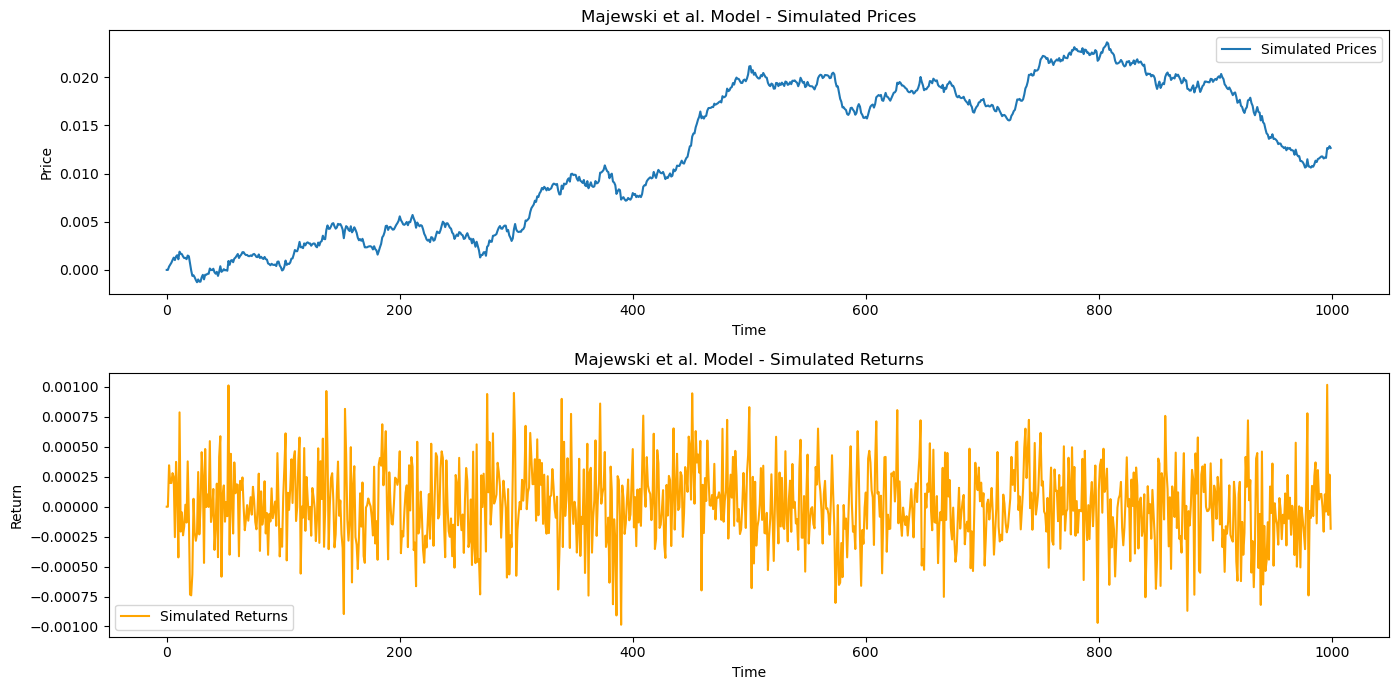

In [9]:
# Parameters for the Majewski model
gamma = 36.7
alpha = 1.0/7
kappa1 = 0.015
beta = 0.015
Lambda = 0.05
sigmav = 0.018
length = 1000
nb = 1

# Run the simulation
prices, returns = Majew(gamma, alpha, kappa1, beta, Lambda, sigmav, length, nb)

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(prices, label='Simulated Prices')
plt.title('Majewski et al. Model - Simulated Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(returns, label='Simulated Returns', color='orange')
plt.title('Majewski et al. Model - Simulated Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()

plt.tight_layout()
plt.show()


### Enhanced Majewski Model Simulation Example


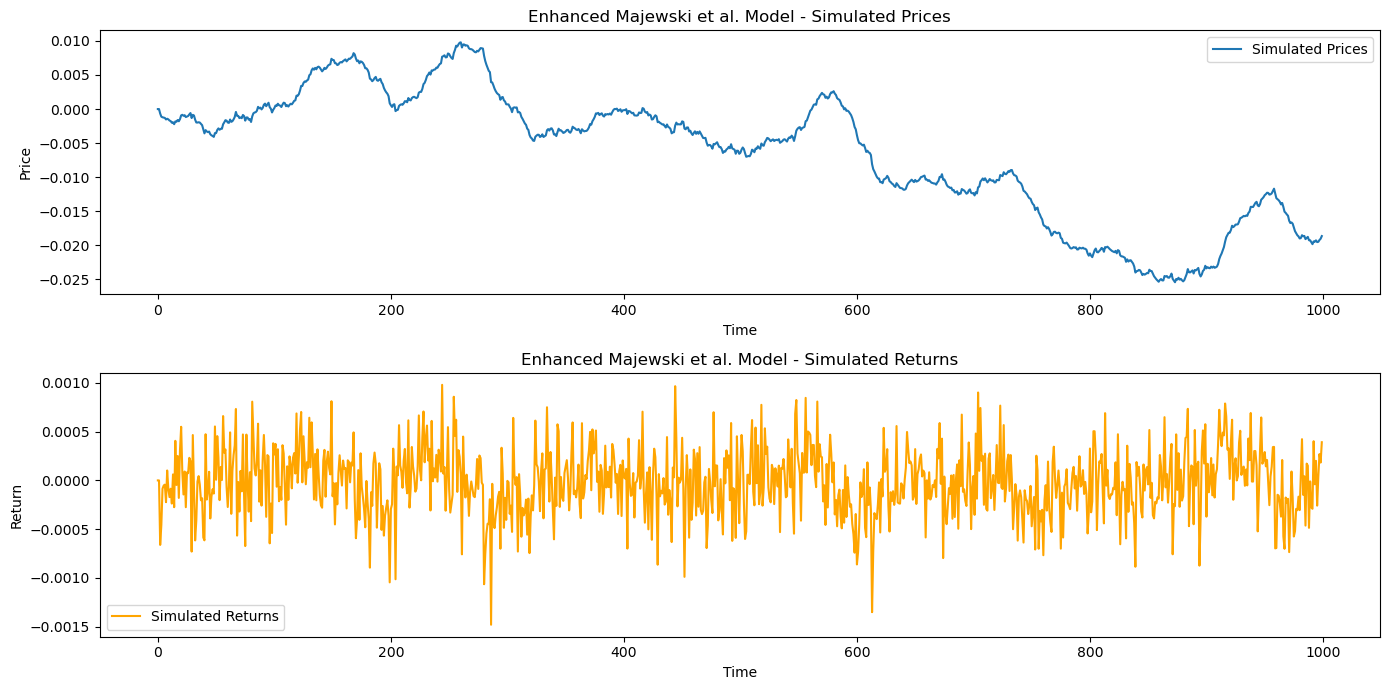

In [8]:
# Parameters for the enhanced Majewski model
gamma = 36.7
alpha = 1.0/7
kappa1 = -0.011000
kappa3 = 0.269000
beta = 0.018
Lambda = 0.1
sigmav = 0.018
length = 1000
nb = 1

# Run the enhanced simulation
prices2, returns2 = Majew2(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, length, nb)

# Plot the results
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(prices2, label='Simulated Prices')
plt.title('Enhanced Majewski et al. Model - Simulated Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(returns2, label='Simulated Returns', color='orange')
plt.title('Enhanced Majewski et al. Model - Simulated Returns')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()

plt.tight_layout()
plt.show()


# Compute Statistics of Returns

The `compute_statistics` function calculates various statistics for a given series of financial returns:
- Mean
- Standard deviation
- Kurtosis
- Ratio of the 10th to 95th percentile of the absolute returns
- Autocorrelation of returns
- Autocorrelation of squared returns

If the `cov` parameter is set to `True`, the function also returns the covariance matrix of these statistics simulations.


In [10]:
def compute_statistics(r, cov=False):
    """
    Compute various statistics for the given return series.

    Parameters:
    r (array-like): Array of return series.
    cov (bool): Whether to return the covariance matrix of the statistics. Default is False.

    Returns:
    tuple: Array of computed statistics. If cov is True, also returns the covariance matrix.
    """
    # Calculate the mean of the returns
    means = np.nanmean(r, axis=0)
    
    # Calculate the standard deviation of the returns
    std_dev = np.nanstd(r, axis=0)
    
    # Calculate the kurtosis of the returns
    kurtosiss = kurtosis(r, axis=0)
    
    # Calculate the 10th and 95th percentiles of the absolute returns
    abs_r = np.abs(r)
    q1 = np.nanpercentile(abs_r, 10, axis=0)
    q2 = np.nanpercentile(abs_r, 95, axis=0)
    rat_quantile = q1 / q2
    
    if r.shape[1] == 1:
        # Calculate the autocorrelation of returns and squared returns for single time series
        aut_r = sm.tsa.acf(r, nlags=1)[1]
        aut_rc = sm.tsa.acf(r**2, nlags=1)[1]
    else:
        # Calculate the autocorrelation of returns and squared returns for multiple time series
        deltar = (r - np.nanmean(r, axis=0)) / np.nanstd(r, axis=0)
        aut_r = np.array([sm.tsa.acf(deltar[:, i], nlags=3)[1] for i in range(r.shape[1])])
        aut_rc = np.array([sm.tsa.acf((deltar[:, i])**2, nlags=3)[1] for i in range(r.shape[1])])

    if cov:
        # Stack all simulations of the statistics for covariance calculation
        mf = np.vstack([means, std_dev, kurtosiss, rat_quantile, aut_r, aut_rc])
        W = np.cov(mf)
        return np.array([np.nanmean(means), np.nanmean(std_dev), np.nanmean(kurtosiss), np.nanmean(rat_quantile), np.nanmean(aut_r), np.nanmean(aut_rc)]), W
    
    return np.array([np.nanmean(means), np.nanmean(std_dev), np.nanmean(kurtosiss), np.nanmean(rat_quantile), np.nanmean(aut_r), np.nanmean(aut_rc)])


### Example: Compute and Plot Statistics


In [16]:
# Parameters for the Majewski  model
gamma = 0.1
alpha = 0.3
kappa1 = 0.2
beta = 0.5
Lambda = 0.4
sigmav = 0.1
length = 1000
nb = 1

# Run the simulation
prices, returns = Majew(gamma, alpha, kappa1, beta, Lambda, sigmav, length, nb)

# Compute statistics
stats = compute_statistics(returns, cov=False)

# Display the computed statistics
print("Mean:", stats[0])
print("Standard Deviation:", stats[1])
print("Kurtosis:", stats[2])
print("Ratio of 10th to 95th Percentile:", stats[3])
print("Autocorrelation of Returns:", stats[4])
print("Autocorrelation of Squared Returns:", stats[5])



Mean: -0.00018057587203194664
Standard Deviation: 0.010059366419768408
Kurtosis: -0.1809321417478289
Ratio of 10th to 95th Percentile: 0.06663799883413539
Autocorrelation of Returns: -0.11875721388820022
Autocorrelation of Squared Returns: -0.01635886551572467


# Cost Function and Optimization


The `cost` function calculates the cost for a given set of parameters $\xi$. It uses the `Majew` function to simulate returns, computes statistics on these returns, and compares them to target statistics $\hat{c}_k$ using a weight matrix $W$.

Given a quantity of interest $c_k$, we measure it in real data $\hat{c}_{k,\mathcal{R}}$ and in the ABM model $\hat{c}_{k,\text{ABM}}(\xi)$. We define the distance as:

$$D_W(\xi) = \sum_{i,k=1}^{K} (\hat{c}_{i,\text{ABM}} - \hat{c}_{i,\mathcal{R}}) W_{ik} (\hat{c}_{k,\text{ABM}} - \hat{c}_{k,\mathcal{R}})$$

The goal is to find $\xi$ that minimizes $D_W$.

To achieve accurate results, we perform many simulations to estimate the covariance matrix $W$. Due to the stochastic nature of the simulations, we compute the average statistics, which best describe the returns using the `compute_statistics` function. This ensures a robust estimation of parameters.


In [11]:
def cost(ksi, W, c_thilde, Majewi=Majew,length=1000):
    """
    Calculate the cost function for the given parameters.

    Parameters:
    ksi (array-like): Parameters for the Majewski et al. model.
    W (array-like): Weight matrix (principally cov matrix) for the cost function.
    c_thilde (array-like): Target statistics.
    Majewi (function): Function to simulate the Majewski model. Default is Majew.

    Returns:
    float: Value of the cost function.
    """
    _, r = Majewi(*ksi, nb=100,length=length)
    cabm, V = compute_statistics(r, cov=True)
    dc = c_thilde - cabm
    D = dc.T @ W @ dc
    return D


# Find Optimal Parameters Function

The `find_optimalksi` function aims to find the optimal parameters $\xi$ for the Majewski model using the Generalized Method of Moments (GMM). This optimization process iteratively updates the parameter estimates and the weight matrix $W$ based on the covariance matrix of the moment conditions. The process follows the recommended iterative procedure as illustrated:

1. Start with an initial weight matrix $W^{(0)}$.
2. Find the optimal parameters $\xi^{(0)}$ by minimizing the cost function.
3. Update the weight matrix $W^{(1)}$ using simulations with $\xi^{(0)}$:
   - Simulate the model many times with $\xi = \xi^{(0)}$.
   - Compute the covariance of the moment conditions between the runs.
4. Repeat steps 2 and 3 until $\left| \xi^{(n)} - \xi^{(n-1)} \right| < \epsilon$.

The goal is to find $\xi$ that minimizes $D_W$.

This function requires extensive simulations to estimate the covariance matrix $W$. Due to the stochastic nature of the simulations, it averages the statistics that best define the returns using the `compute_statistics` function. This ensures a robust estimation of parameters.


The error is calculated to determine the convergence of the optimization process. The error is defined as the L1 norm of the relative change in parameters between successive iterations.

Mathematically, it is represented as:

$$
\text{error} = \left\| \left| \frac{\xi^{(n+1)}}{\xi^{(n)}} \right| - \mathbf{1} \right\|_1
$$

where:
- $\xi^{(n)}$ and $\xi^{(n+1)}$ are the parameter vectors at the $n$-th and $(n+1)$-th iterations respectively.
- $\mathbf{1}$ is a vector of ones.

This calculation measures the relative change in each parameter, scaled to avoid issues with parameters of different magnitudes. The L1 norm (sum of absolute values) is used to aggregate the changes into a single error metric. The optimization process continues until this error falls below a specified threshold $\epsilon$, indicating that the parameters have converged.




In [12]:
def find_optimalksi(params=[36.7, 1/7, 0.015, 0.015, 0.05, 0.018], cost=cost,\
     Majewi=Majew, epsilon=0.1, maxiter=100, print_res=True, dis=True, c_thilde=[],length=1000):
     
    """
    Find the optimal parameters for the Majewski et using the given cost function.

    Parameters:
    params (list): Initial parameters for the Majewski model.
    cost (function): Cost function to minimize. Default is cost.
    Majewi (function): Function to simulate the Majewski  model. Default is Majew.
    epsilon (float): Convergence threshold. Default is 0.1.
    maxiter (int): Maximum number of iterations. Default is 100.
    print_res (bool): Whether to print intermediate results. Default is True.
    dis (bool): Whether to display optimization output. Default is True.
    c_thilde (list): Target statistics. Default is an empty list.

    Returns:
    tuple: Target statistics and optimized parameters.
    """
    # If target statistics are not provided, simulate initial parameters to get target statistics
    if len(c_thilde) == 0:
        _, r_thild = Majewi(*params)
        c_thilde = compute_statistics(r_thild)
    
    # Define bounds for the optimization based on a percentage range around initial parameters
    percentage_range = 0.3  # 30% range
    bounds = [(min(param * (1 - percentage_range), param * (1 + percentage_range)), 
               max(param * (1 - percentage_range), param * (1 + percentage_range))) for param in params]
    
    # Options for the optimization algorithm
    options = {'maxiter': 1000, 'disp': dis}
    
    # Initialize parameters randomly within the bounds
    ksi = [np.random.uniform(low, high) for low, high in bounds]
    
    # Simulate returns with the initial parameters
    _, r = Majewi(*ksi, nb=100,length=length)
    # Compute statistics and covariance matrix
    cabm, V = compute_statistics(r, cov=True)
    # Compute the inverse of the covariance matrix to get the weight matrix
    W = np.linalg.inv(V)
    
    i = 1
    while True:
        # Minimize the cost function
        res = minimize(cost, ksi, args=(W, c_thilde, Majewi,length), method='Powell', bounds=bounds, options=options)
        # Calculate the error as the norm of the relative change in parameters
        error = np.linalg.norm(np.abs(res.x / ksi) - np.ones(len(params)), ord=1)
        
        if print_res:
            print(f"Step {i} result: ", error)
            print(f"n : {ksi}\nn+1 : {res.x}")
        
        # Update parameters
        ksi = res.x
        if (error < epsilon) or (i >= maxiter):
            break
        
        # Simulate returns with updated parameters
        _, r = Majewi(*ksi, nb=100,length=length)
        # Compute statistics and update the weight matrix
        cabm, V = compute_statistics(r, cov=True)
        W = np.linalg.inv(V)
        i += 1

    return c_thilde, ksi



## Simulation Examples

### Example 1: Default Majew Model
- Optimize parameters using the default `Majew` model.
- Settings: `dis=False`, `epsilon=0.5`, `maxiter=50`.

### Example 2: Enhanced Majew2 Model
- Optimize parameters using the `Majew2` model with custom parameters.
- Initial params: `[36.7, 1/7, -0.011000, 0.269000, 0.018, 0.1, 0.018]`.
- Settings: `print_res=True`, `dis=True`, `epsilon=0.5`, `maxiter=50`.


In [24]:
# Example 1: Using find_optimalksi with default Majew model
c_thilde, ksi = find_optimalksi(dis=False, epsilon=0.5, maxiter=50)
print("Optimal ksi (Majew model):", ksi)

Step 1 result:  0.5399796057410589
n : [36.32067522110854, 0.13712521466187166, 0.012310186887355953, 0.014721187176309622, 0.04499822464621908, 0.017217184334696822]
n+1 : [3.71774392e+01 1.11660281e-01 1.49607629e-02 1.50638818e-02
 4.25298844e-02 1.78582867e-02]
Step 2 result:  0.5660705229046801
n : [3.71774392e+01 1.11660281e-01 1.49607629e-02 1.50638818e-02
 4.25298844e-02 1.78582867e-02]
n+1 : [3.86819126e+01 1.31612319e-01 1.73753882e-02 1.60623059e-02
 4.74285796e-02 1.79307735e-02]
Step 3 result:  0.38989485111549027
n : [3.86819126e+01 1.31612319e-01 1.73753882e-02 1.60623059e-02
 4.74285796e-02 1.79307735e-02]
n+1 : [3.92133508e+01 1.20234398e-01 1.49465843e-02 1.57523292e-02
 5.33518661e-02 1.78279440e-02]
Optimal ksi (Majew model): [3.92133508e+01 1.20234398e-01 1.49465843e-02 1.57523292e-02
 5.33518661e-02 1.78279440e-02]


In [25]:
# Example 2: Using find_optimalksi with Majew2 model
params = [36.7, 1/7, -0.011000, 0.269000, 0.018, 0.1, 0.018]
c_thilde, ksi = find_optimalksi(Majewi=Majew2, params=params, print_res=False, dis=True, epsilon=0.5, maxiter=50)
print("Optimal ksi (Majew2 model):", ksi)

Optimization terminated successfully.
         Current function value: 10.134070
         Iterations: 3
         Function evaluations: 345
Optimization terminated successfully.
         Current function value: 9.971753
         Iterations: 2
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: 12.634520
         Iterations: 1
         Function evaluations: 98
Optimal ksi (Majew2 model): [ 3.93674942e+01  1.32585882e-01 -9.09899701e-03  2.46619772e-01
  1.67252329e-02  8.75029022e-02  1.78796722e-02]


# Densities Calculation Function

The `densities` function repeats the optimization process multiple times to obtain the distribution of optimal parameters $\xi$. This is to analyse the variability and robustness of the parameter estimates.

1. **Initial Simulation**:
   - Simulate returns with the initial parameters to compute the target statistics $\hat{c}_{\tilde{c}}$.

2. **Optimization Loop**:
   - Perform the optimization `nb_simulations` times.
   - In each iteration, the function `find_optimalksi` is called to find the optimal parameters $\xi$.
   - Append the optimal parameters from each iteration to the list `ksi`.

3. **Output**:
   - The function returns a list of optimal parameter sets obtained from each simulation, allowing for the analysis of their distribution.

This repeated optimization process provides insight into the stability and reliability of the estimated parameters under different initial conditions and stochastic variations.


In [13]:
def densities(nb_simulations=100, params=[36.7, 1/7, 0.015, 0.015, 0.05, 0.018], \
    cost=cost, Majewi=Majew, epsilon=0.3, maxiter=100, print_res=True):
    """
    Repeat the optimization process multiple times to obtain the distribution of optimal parameters.

    Parameters:
    nb_simulations (int): Number of simulations to perform. Default is 100.
    params (list): Initial parameters for the Majewski model.
    cost (function): Cost function to minimize. Default is cost.
    Majewi (function): Function to simulate the Majewski model. Default is Majew.
    epsilon (float): Convergence threshold. Default is 0.3.
    maxiter (int): Maximum number of iterations. Default is 100.
    print_res (bool): Whether to print intermediate results. Default is True.

    Returns:
    list: List of optimal parameter sets obtained from each simulation.
    """
    # Simulate returns with initial parameters to get target statistics
    _, r_thild = Majewi(*params)
    c_thilde = compute_statistics(r_thild)

    ksi = []
    for i in tqdm(range(nb_simulations)):
        # Perform the optimization to find optimal parameters
        optimal_ksi = find_optimalksi(params=params, cost=cost, Majewi=Majewi, epsilon=epsilon, maxiter=maxiter, print_res=False, dis=False, c_thilde=c_thilde)[1]
        ksi.append(optimal_ksi)
        if print_res:
            print(optimal_ksi)

    return ksi


## Simulation Densities Examples

### Example 1: Default Majew Model
- Compute densities using the default `Majew` model.
- Initial params: `[36.7, 1/7, 0.015, 0.015, 0.05, 0.018]`.
- Settings: `epsilon=0.41`, `maxiter=100`, `print_res=False`.

### Example 2: Enhanced Majew2 Model
- Compute densities using the `Majew2` model with custom parameters.
- Initial params: `[36.7, 1/7, -0.011000, 0.269000, 0.018, 0.1, 0.018]`.
- Settings: `epsilon=0.3`, `maxiter=100`, `print_res=False`.


In [26]:
params1 = np.array([36.7, 1/7, 0.015, 0.015, 0.05, 0.018])
ksis1 = densities(Majewi=Majew, params=params1, epsilon=0.41, maxiter=100, print_res=False)

In [27]:
params2 = [36.7, 1/7, -0.011000, 0.269000, 0.018, 0.1, 0.018]
ksis2 = densities(Majewi=Majew2, params=params2, epsilon=0.3, maxiter=100, print_res=False)

The histograms below show the distributions of the optimized parameters $\xi$ for two different models: the default `Majew` model and the enhanced `Majew2` model. For each parameter, the histogram displays:

- **True Value**: The initial parameter value (red dashed line).
- **Mean Value**: The average of the optimized parameter values from multiple simulations (green dashed line).

These plots help visualize the variability and robustness of the parameter estimates.


In [14]:
# Function to plot histograms for the optimized parameters
def plot_histograms(ksis, params, model_name):
    num_params = ksis.shape[1]

    plt.figure(figsize=(14, num_params * 4))

    for i in range(num_params):
        plt.subplot(num_params, 1, i + 1)
        plt.hist(ksis[:, i], bins=30, alpha=0.75, color='blue', edgecolor='black')
        plt.axvline(params[i], color='red', linestyle='dashed', linewidth=2, label='True Value')
        plt.axvline(np.mean(ksis[:, i]), color='green', linestyle='dashed', linewidth=2, label='Mean Value')
        plt.title(f'{model_name} - Parameter {i+1} Histogram')
        plt.xlabel('Parameter Value')
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.show()


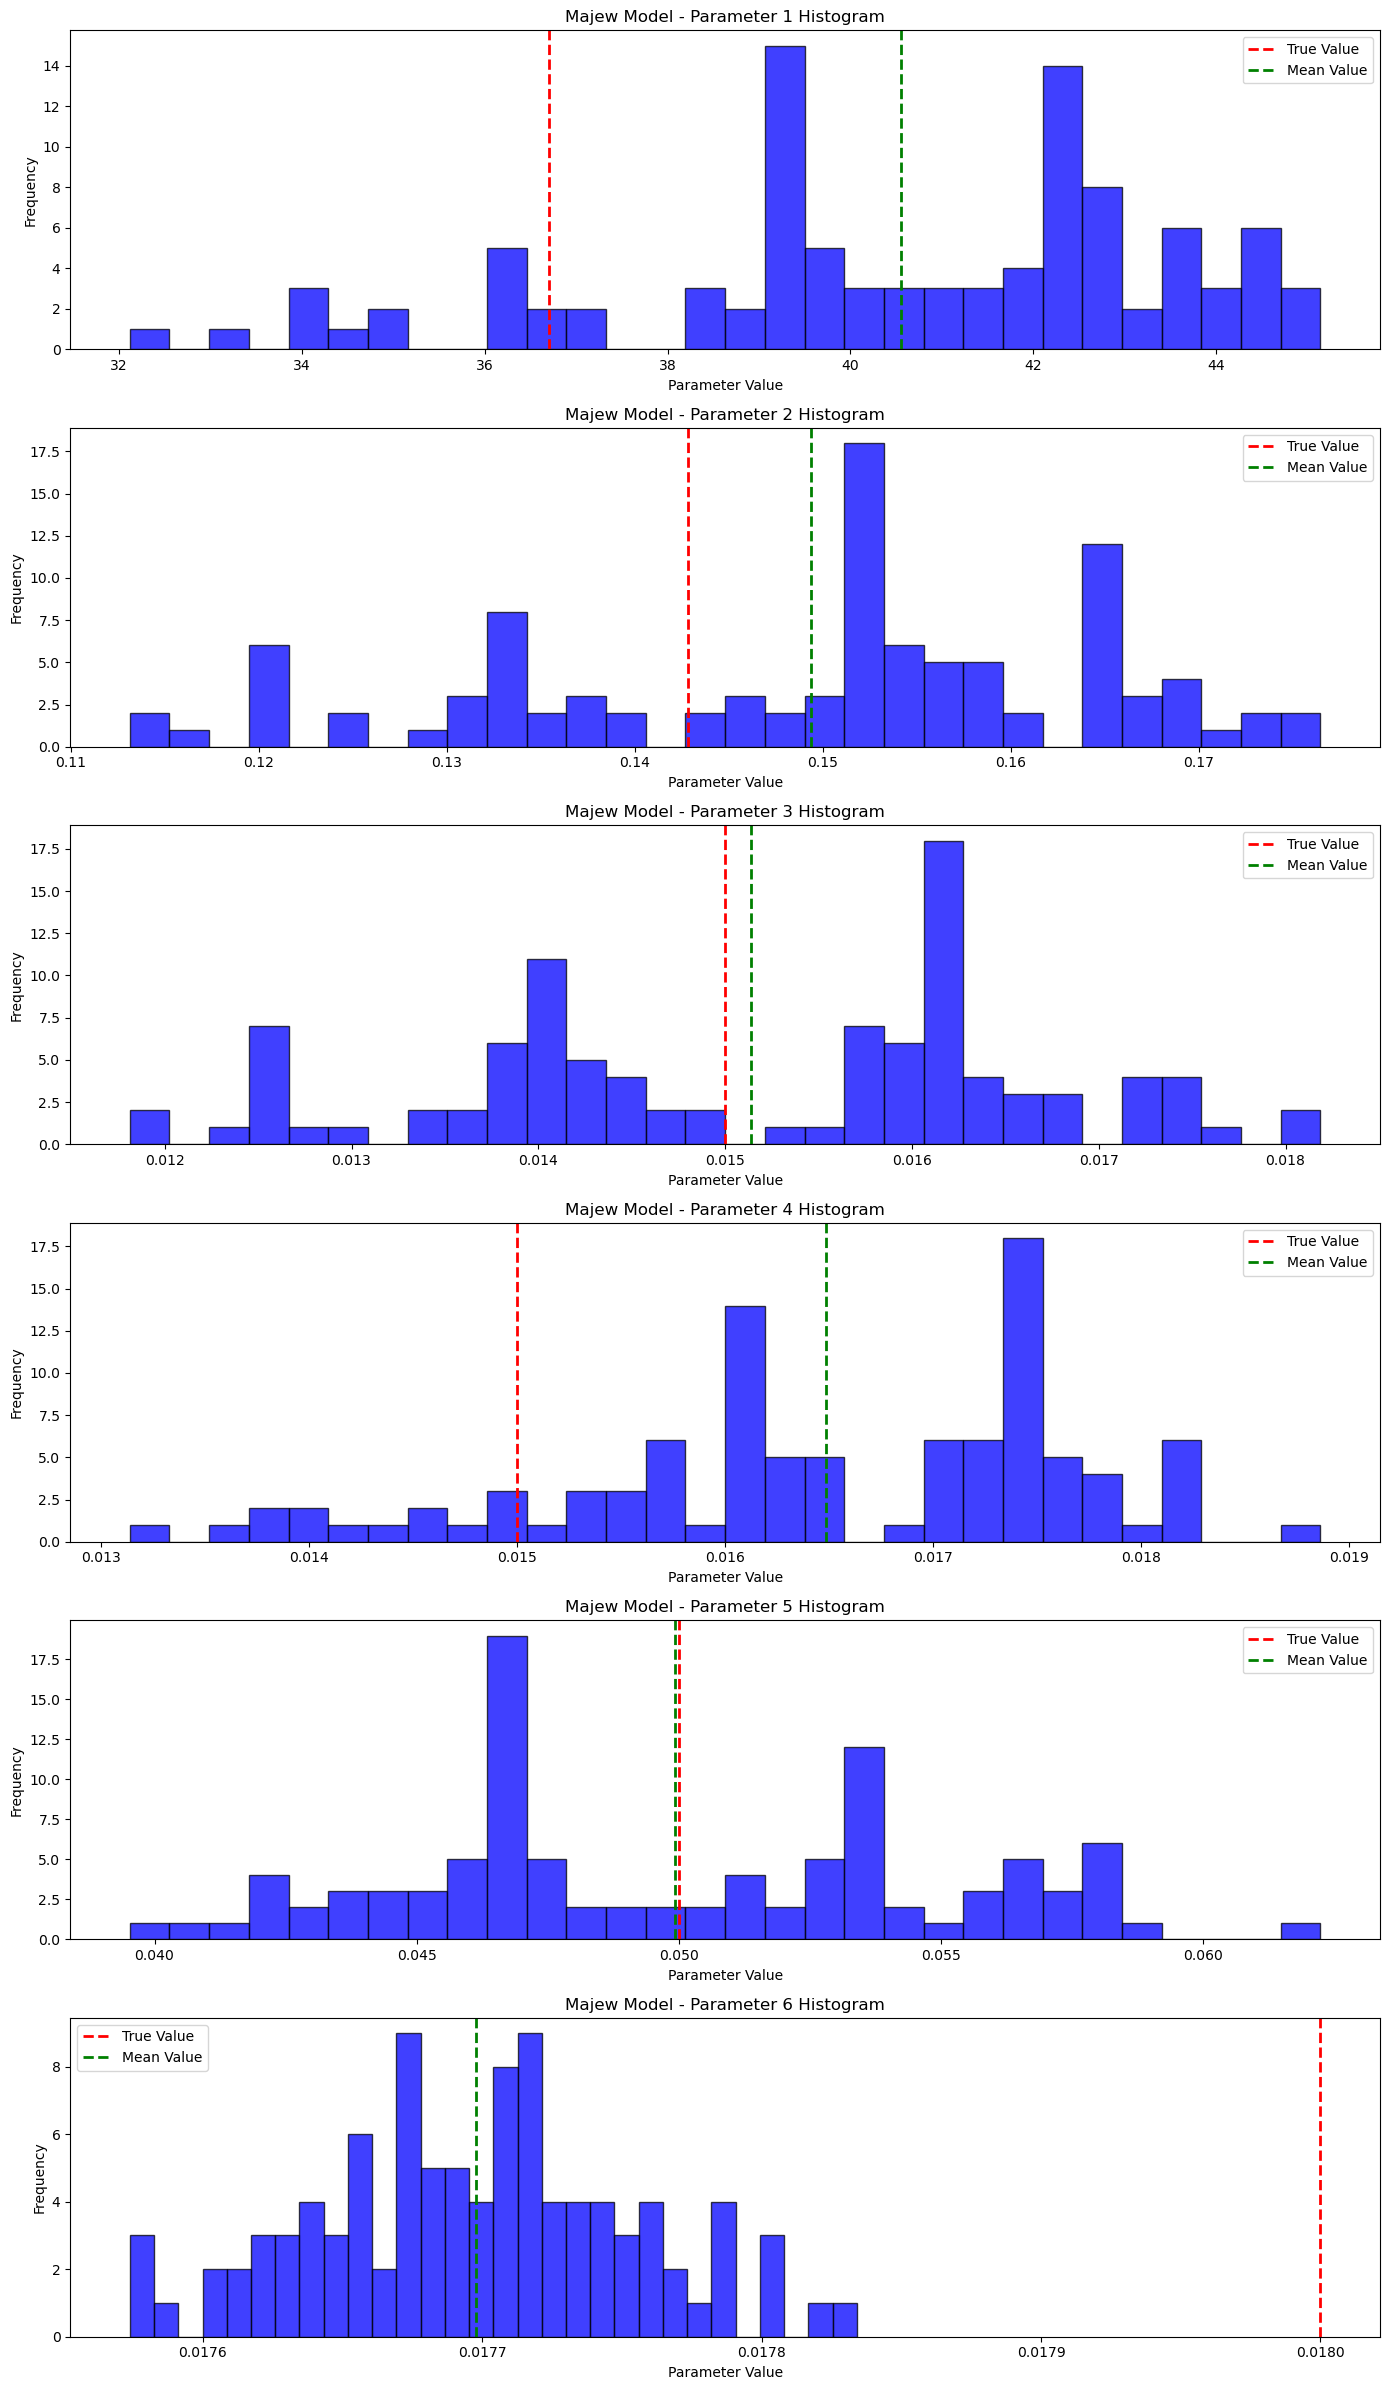

In [31]:
# Example 1: Compute densities using default Majew model
ksis1 = np.vstack(ksis1)
plot_histograms(ksis1, params1, "Majew Model")

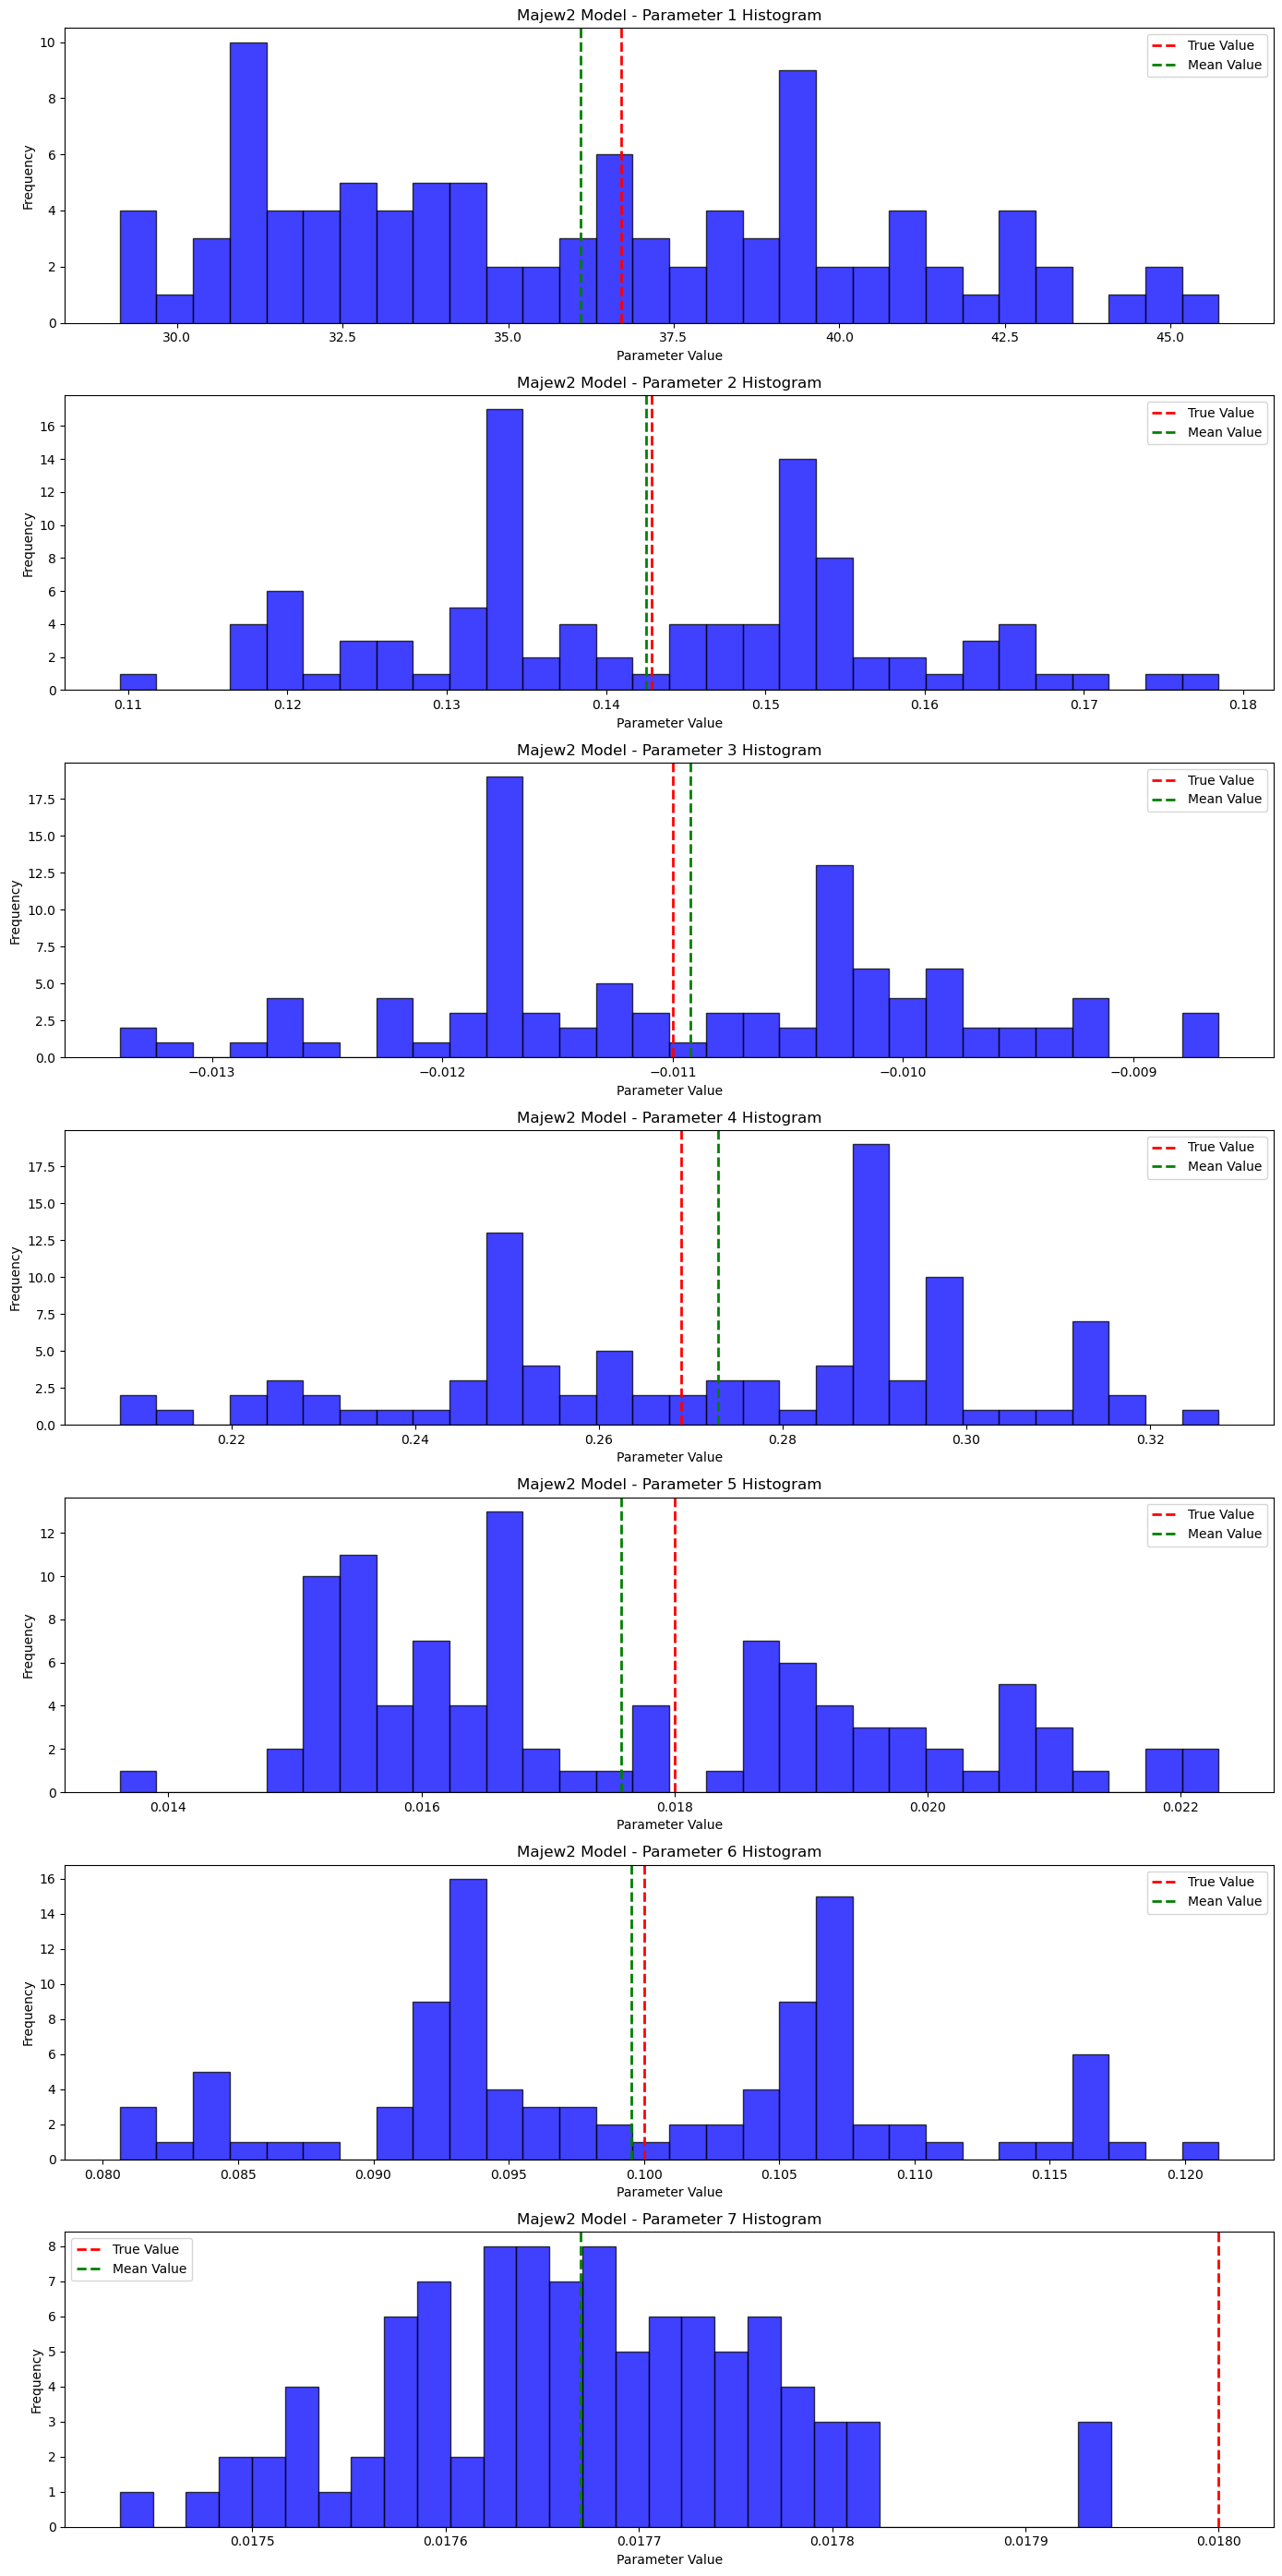

In [32]:
ksis2 = np.vstack(ksis2)
plot_histograms(ksis2, params2, "Majew2 Model")

# Model Class for Sliding Window Predictions

The `Model` class implements a financial time series model with a sliding window approach for fitting and predicting future prices.

## Methods

#### `__init__(self, ksi)`
Initializes the model with default or provided parameters.

#### `fit(self, r)`
Fits the model to the provided returns data by calculating target statistics and finding optimal parameters.

#### `predict(self, r, prices, T, deltat, nbshift)`
Predicts future prices using the fitted model with a sliding window approach:
- `r`: Returns data.
- `prices`: Prices data.
- `T`: Length of the calibration window.
- `deltat`: Step size for sliding the window.
- `nbshift`: Number of shifts for the sliding window.

Returns a dictionary of predictions for each shift.


In [21]:
class Model:
    """
    Model class for fitting and predicting financial time series using a sliding window approach.
    
    Attributes:
    ksif (array-like): Initial parameters for the model.
    optimal_ksi (array-like): Optimal parameters found after fitting the model.
    """
    
    def __init__(self, ksi=[36.7, 1/7, -0.011000, 0.269000, 0.018, 0.1, 0.018]):
        """
        Initialize the Model class with default or provided parameters.
        
        Parameters:
        ksi (list): Initial parameters for the model.
        """
        self.ksif = np.array(ksi)
        self.optimal_ksi = None

    def fit(self, r):
        """
        Fit the model to the provided returns data.
        
        Parameters:
        r (array-like): Returns data used to fit the model.
        """
        # Calculate the target statistics c_tilde
        c_tilde = compute_statistics(r)
        
        # Find the optimal parameters using find_optimalksi
        self.optimal_ksi = find_optimalksi(params=self.ksif, Majewi=Majew2, epsilon=1, maxiter=100,
                                           c_thilde=c_tilde, print_res=True, dis=True)[1]

    def predict(self, r, prices, T, deltat=10, nbshift=0):
        """
        Predict future prices using the fitted model with a sliding window approach.
        
        Parameters:
        r (array-like): Returns data.
        prices (array-like): Prices data.
        T (int): Length of the calibration window.
        deltat (int): Step size for sliding the window. Default is 10.
        nbshift (int): Number of shifts for the sliding window. Default is 0.
        
        Returns:
        dict: Predictions for each shift.
        """
        

        length = len(prices)
        v = np.zeros(length)
        m = np.zeros(length)
        p = np.zeros(shape=len(prices))
        p[:T] = prices[:T, 0]
        prediction = {}
        
        for i in range(nbshift + 1):
            
            # Fit the model with the current window
            self.fit(r[deltat * i:T + deltat * i])
            # Extract the optimal parameters
            gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav = self.optimal_ksi
            Epsilon = np.random.normal(0, sigmav**2, prices.shape[0])

            #define the window 
            p[(deltat * i):T + (deltat * i)] = prices[(deltat * i):T + (deltat * i), 0]
            v = np.zeros(length)
            m = np.zeros(length)

            for t in range(1 + (deltat * i), T + (deltat * i) - 1):
                # Update the fundamental value
                v[t] = (1 - Lambda) * v[t - 1] + Lambda * prices[t]
                
                # Update the moving average of the trend
                m[t] = (1 - alpha) * m[t - 1] + alpha * (prices[t] - prices[t - 1])
                
            for t in range(-1 + T + (deltat * i), min(-1 + T + (deltat * (i + 1)), len(prices) - 1)):
                # Update the fundamental value
                v[t] = (1 - Lambda) * v[t - 1] + Lambda * p[t]
        
                # Update the moving average of the trend
                m[t] = (1 - alpha) * m[t - 1] + alpha * (p[t] - p[t - 1])
                
                # Update the price with an additional cubic term
                p[t + 1] = p[t] + kappa1 * (v[t] - p[t]) + kappa3 * (v[t] - p[t])**3 + beta * np.tanh(gamma * m[t]) + Epsilon[t + 1]
                
                # Calculate the return
                r[t + 1] = p[t + 1] - p[t]
                
            # Store the predicted prices for the current shift
            prediction[i] = deepcopy(p[T + (deltat * i):min(T + (deltat * (i + 1)), len(prices))])

            
        return prediction


# Simulation Function for Majew2 Model

The `Simulation2T` function simulates returns using the Majew2 model, fits the model to the first half of the data, and predicts future prices.

### Steps:
1. **Simulate Data**:
   - Simulate returns `r` and prices `p` using the Majew2 model with the given parameters for a length of `2T`.

2. **Initialize Model**:
   - Create an instance of the `Model` class with the given parameters.

3. **Fit Model**:
   - Fit the model using the returns data from `0` to `T` to find the optimal parameters.

4. **Predict Future Prices**:
   - Use the fitted model to predict prices from `T` to `2T`.

### Parameters:
- `gamma`, `alpha`, `kappa1`, `kappa3`, `beta`, `Lambda`, `sigmav`: Parameters of the Majew2 model.
- `T`: Length of the calibration window.

### Returns:
- Simulated prices `p`.
- Simulated returns `r`.
- Predicted prices `prediction`.


In [19]:
def Simulation2T(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, T):
    """
    Simulate returns using the Majew2 model, fit the model, and predict future prices.

    Parameters:
    gamma (float): Parameter gamma in the model.
    alpha (float): Parameter alpha in the model.
    kappa1 (float): Parameter kappa1 in the model.
    kappa3 (float): Parameter for the cubic term in the model.
    beta (float): Parameter beta in the model.
    Lambda (float): Parameter Lambda in the model.
    sigmav (float): Standard deviation of the noise term.
    T (int): Length of the calibration window.

    Returns:
    tuple: Simulated prices, returns, and predictions.
    """
    # Simulate returns using the Majew2 model
    p, r = Majew2(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, length=2*T)

    # Initialize the Model with the given parameters
    model = Model([gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav])

    # Fit the model using the first half of the simulated data
    model.fit(r[:T])

    # Predict future prices using the fitted model
    prediction = model.predict(r, p, T, deltat=T, nbshift=0)

    return p, r, prediction

        
    

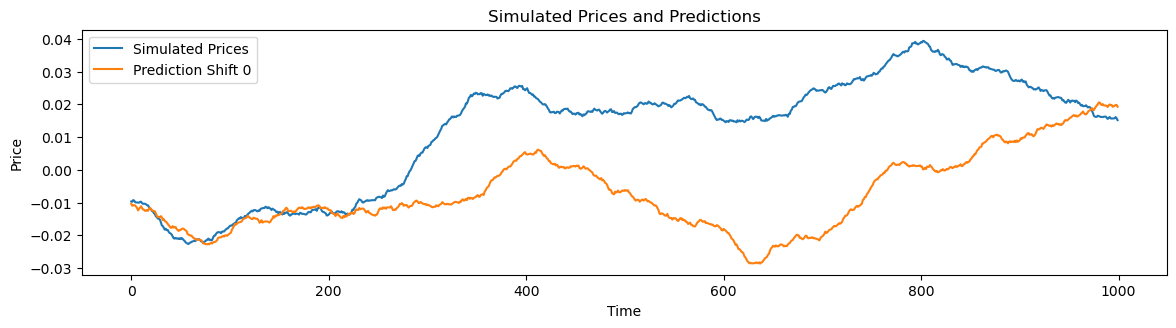

In [26]:
# Parameters for the Majew2 model
gamma = 36.7
alpha = 1/7
kappa1 = -0.011
kappa3 = 0.269
beta = 0.018
Lambda = 0.05
sigmav = 0.018
T = 1000

# Run the simulation
p, r, prediction = Simulation2T(gamma, alpha, kappa1, kappa3, beta, Lambda, sigmav, T)

# # Plot the results
plt.figure(figsize=(14, 7))

# Plot the simulated prices
plt.subplot(2, 1, 1)
plt.plot(p[1000:], label='Simulated Prices')
plt.title('Simulated Prices and Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.plot(pred, label=f'Prediction Shift {i}')

plt.legend()
plt.show()


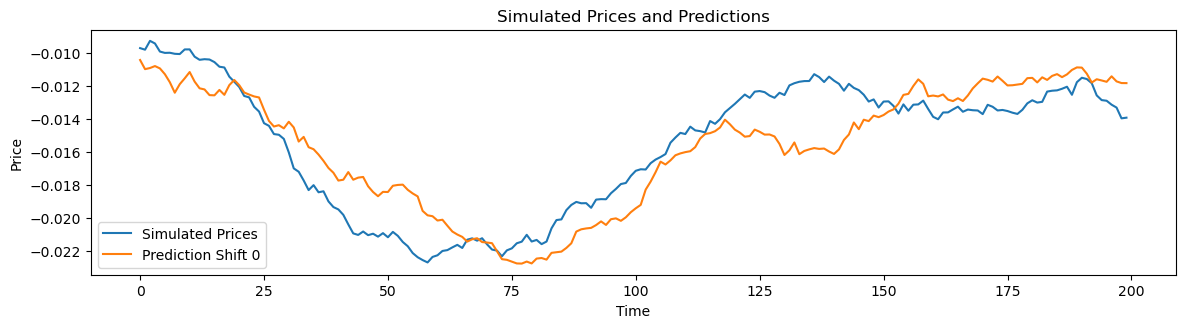

In [27]:
# # Plot the results
plt.figure(figsize=(14, 7))

# Plot the simulated prices
plt.subplot(2, 1, 1)
plt.plot(p[1000:1200], label='Simulated Prices')
plt.title('Simulated Prices and Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.plot(pred[:200], label=f'Prediction Shift {i}')

plt.legend()
plt.show()

From the plots above, we observe the following:

- **Initial Performance**: The model performs well for the first 200 time steps. The predicted prices closely follow the simulated prices, indicating that the model accurately captures the underlying dynamics during this period.

- **Degradation of Performance**: Beyond 200 time steps, the model's predictions start to deviate significantly from the actual prices. This suggests that the model's parameters are no longer optimal, and the model's assumptions might not hold over a longer time horizon.

### Possible Explanation: Stationarity of Time Series

The initial good performance followed by degradation suggests that the time series might be non-stationary. This can affect the model's ability to predict accurately over longer periods without recalibration.

To investigate this, we can check the stationarity of the time series using the Autocorrelation Function (ACF) and the Augmented Dickey-Fuller (ADF) test.

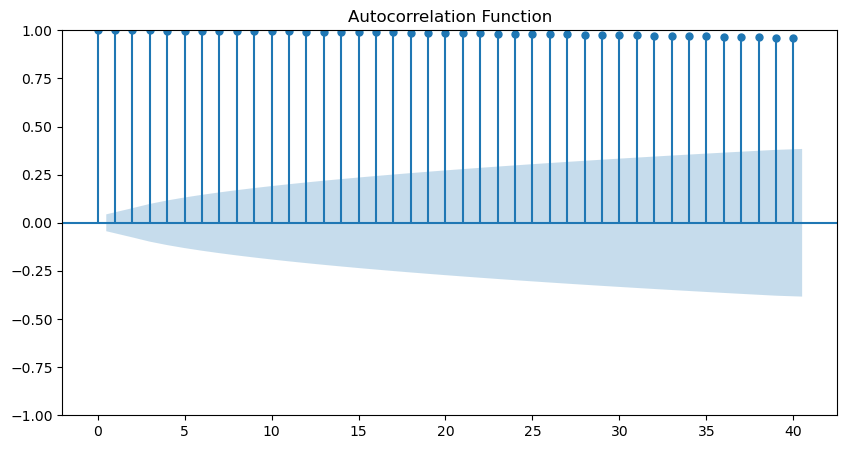

ADF Statistic: -0.8554460839529081
p-value: 0.8022905245539724


In [29]:
def check_stationarity(prices):
    """
    Check the stationarity of the time series using ACF and ADF test.

    Parameters:
    prices (array-like): The prices time series to check.

    Returns:
    None
    """
    # Plot ACF
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sm.graphics.tsa.plot_acf(prices, lags=40, ax=ax)
    plt.title('Autocorrelation Function')
    plt.show()
    
    # Perform ADF test
    result = adfuller(prices)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])



check_stationarity(p)


- **ACF Plot**: Significant autocorrelation at all lags indicates non-stationarity.
- **ADF Test**:
  - **ADF Statistic**: -0.855
  - **p-value**: 0.802 (not significant)

The high p-value (> 0.05) suggests the presence of a unit root, confirming non-stationarity. This explains the initial good performance and subsequent degradation of the model. Recalibration is necessary for accurate long-term predictions.

In [42]:
def success(p_ref, p_cal):
    """
    Calculate Mean Absolute Error (MAE) and hit ratio for actual vs predicted prices using NumPy operations.

    Parameters:
    p_ref (array-like): Reference (actual) prices.
    p_cal (array-like): Calculated (predicted) prices.

    Returns:
    tuple: MAE and hit ratio.
    """
    # Ensure arrays are the same length
    n = min(len(p_ref), len(p_cal))
    
    # Calculate the differences and their absolute values
    p_dif_abs = np.abs(p_ref[:n] - p_cal[:n])
    
    # Calculate the hit ratio
    ref_diff = np.diff(p_ref[:n])
    cal_diff = np.diff(p_cal[:n])
    hits = (ref_diff * cal_diff) >= 0
    hit_ratio = np.mean(hits)
    
    # Calculate MAE
    mae = np.mean(p_dif_abs)
    
    return mae, hit_ratio



test = success(p[1000:1200], pred[:200])
print(f"For 200 first prices : MAE = {test[0]}, Hit Ratio = {test[1]}")

test = success(p[1000:], pred)
print(f"For all prices : MAE = {test[0]}, Hit Ratio = {test[1]}")


For 200 first prices : MAE = 2.4103696119901667, Hit Ratio = 0.45226130653266333
For all prices : MAE = 2.6857358707781147, Hit Ratio = 0.5206611570247934


# Testing the Model on Real Data

We will test our model on real financial data to evaluate its performance. The model will be fitted to a segment of the historical price data of length $T$, and then used to predict future prices up to a specified step size $\Delta_t$. This process will be repeated for a given number of shifts, each time shifting the window forward by $\Delta_t$ and refitting the model.

### Steps:
1. **Load Real Data**: Import historical price data.
2. **Fit the Model**: Use the real data to fit the model over a window of length $T$.
3. **Predict Prices**: Use the fitted model to predict prices up to $\Delta_t$ time steps ahead.
4. **Re-train and Shift**: Shift the window by $\Delta_t$, refit the model, and repeat the predictions.
5. **Evaluate Performance**: Calculate Mean Absolute Error (MAE) and Hit Ratio to assess the accuracy of the predictions.

In [52]:
def p_r(prices):
    """
    Calculate the log of prices and returns from a DataFrame.

    Parameters:
    prices (DataFrame): DataFrame containing a 'close' column with the closing prices.

    Returns:
    tuple: Log of prices and returns.
    """
    # Extract the 'close' prices
    prices = prices['Close'].values
    
    # Calculate returns
    R = prices[1:] / prices[:-1]
    r = np.log(R)
    r = np.insert(r, 0, 0)
    
    # Calculate log prices
    log_prices = np.log(prices)
    
    return log_prices, r


In [63]:
# Download historical price data for a stock (e.g., Apple)
ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

# Calculate log prices and returns
p, r = p_r(data)

# Initialize and fit the model
model = Model([36.7, 1/7, -0.011, 0.269, 0.018, 0.1, 0.018])
r2 = np.zeros(shape=(len(r), 1))
r2[:, 0] = r
p2 = np.zeros(shape=(len(p), 1))
p2[:, 0] = p
T = 500
# Predict future prices
prediction = model.predict(r2, p2,T , deltat=150, nbshift=1)



[*********************100%%**********************]  1 of 1 completed

Optimization terminated successfully.
         Current function value: 3205382.584715
         Iterations: 4
         Function evaluations: 510
Step 1 result:  1.1028937001338441
n : [44.849022048085146, 0.1246819565454313, -0.00930190193901488, 0.2160693668405207, 0.015452226938064409, 0.10844719261179132, 0.01987231485742976]
n+1 : [ 4.73446855e+01  1.16835647e-01 -1.19350572e-02  2.08534236e-01
  2.13533662e-02  9.60750132e-02  2.32582777e-02]
Optimization terminated successfully.
         Current function value: 379732.364950
         Iterations: 2
         Function evaluations: 206
Step 2 result:  1.6551657587155029
n : [ 4.73446855e+01  1.16835647e-01 -1.19350572e-02  2.08534236e-01
  2.13533662e-02  9.60750132e-02  2.32582777e-02]
n+1 : [ 3.07475462e+01  1.03428284e-01 -1.04157451e-02  2.76337395e-01
  1.37321217e-02  1.09260374e-01  1.76004419e-02]
Optimization terminated successfully.
         Current function value: 7619783.189887
         Iterations: 3
         Function eval